In [1]:
from Model.DCVAE import DCVAE
from Model.Utils import PlotHistory, PlotDataAE, Save_Model
from Model.Utils import load_from_tfrecords, convert_to_tfrecords, load_numpy
from keras.optimizers import RMSprop,Adam
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
%matplotlib notebook

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Load DataSet

In [2]:
load_tfrecords = True 
create_tfrecords = False

path_tfr = 'DataSet/MPS100'
path_npy = '/share/GeoFacies/DataSet/MPS100/MPS100.npy'
batch_size = 128

In [3]:
if load_tfrecords: 
    if create_tfrecords: 
        x_train, x_test = load_numpy(path_npy,random_state=0,split_data=0.30)
        convert_to_tfrecords(path_tfr, x_train, x_test)
        gen_train, gen_test = load_from_tfrecords(path_tfr, batch_size)
    else:
        try:
            gen_train, gen_test = load_from_tfrecords(path_tfr, batch_size)
        except:
            print("Data not found. Change 'create_tfrecords' to True")
else:
    x_train, x_test = load_numpy(path_npy,random_state=0,split_data=0.30)

# Create Convolutional Variational Autoencoder

In [4]:
path_weights = os.path.join(path_tfr, 'w100.hdf5')

model = DCVAE(input_shape=(100, 100, 2),filters=[32,32,16],strides=[2,2,1],hidden_dim=5000,
              KernelDim=(5,5,3),latent_dim=500,opt=Adam(1e-4),dropout=0.1,epochs_drop=200,filepath=path_weights)

# Training Network

In [5]:
num_epochs = 500

if load_tfrecords:
    x_train = gen_train.mps_generator()
    x_val = gen_test.mps_generator()
    model.fit_generator(x_train,
                        num_epochs=num_epochs, verbose=1, 
                        steps_per_epoch = len(gen_train),
                        val_set = x_val,
                        validation_steps = len(gen_test))
else:
    model.fit(x_train, num_epochs=num_epochs, batch_size = batch_size, x_v=x_test,verbose=1) 

Setting up model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 32)   1632        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 25, 32)   25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 16)   4624        conv2d_2

Epoch 1/500


218/218 [==============================] - 61s 279ms/step - loss: 6155.6626 - acc_pred: 0.6760 - val_loss: 5322.2704 - val_acc_pred: 0.6854
Epoch 2/500


218/218 [==============================] - 54s 250ms/step - loss: 4068.7505 - acc_pred: 0.8093 - val_loss: 3082.6596 - val_acc_pred: 0.8741
Epoch 3/500


218/218 [==============================] - 52s 240ms/step - loss: 2824.7567 - acc_pred: 0.8894 - val_loss: 2548.7567 - val_acc_pred: 0.9033
Epoch 4/500


218/218 [==============================] - 55s 254ms/step - loss: 2489.5300 - acc_pred: 0.9072 - val_loss: 2333.2172 - val_acc_pred: 0.9144
Epoch 5/500


218/218 [==============================] - 55s 250ms/step - loss: 2333.1293 - acc_pred: 0.9150 - val_loss: 2205.7752 - val_acc_pred: 0.9208
Epoch 6/500


218/218 [==============================] - 54s 249ms/step - loss: 2231.6686 - acc_pred: 0.9200 - val_loss: 2131.7898 - val_acc_pred: 0.9245
Epoch 7/500


218/218 [==============================] - 54s 249ms/step - loss: 2153.7164 - acc_pred: 0.9238 - val_loss: 2069.9272 - val_acc_pred: 0.9271
Epoch 8/500


218/218 [==============================] - 53s 242ms/step - loss: 2094.4947 - acc_pred: 0.9266 - val_loss: 2016.0122 - val_acc_pred: 0.9294
Epoch 9/500


218/218 [==============================] - 52s 239ms/step - loss: 2046.3081 - acc_pred: 0.9288 - val_loss: 1971.5800 - val_acc_pred: 0.9318
Epoch 10/500


218/218 [==============================] - 53s 244ms/step - loss: 2001.8919 - acc_pred: 0.9308 - val_loss: 1935.7482 - val_acc_pred: 0.9334
Epoch 11/500


218/218 [==============================] - 54s 250ms/step - loss: 1964.0332 - acc_pred: 0.9324 - val_loss: 1898.1434 - val_acc_pred: 0.9351
Epoch 12/500


218/218 [==============================] - 53s 242ms/step - loss: 1931.3791 - acc_pred: 0.9339 - val_loss: 1866.4639 - val_acc_pred: 0.9364
Epoch 13/500


218/218 [==============================] - 53s 243ms/step - loss: 1902.0406 - acc_pred: 0.9351 - val_loss: 1855.8285 - val_acc_pred: 0.9365
Epoch 14/500


218/218 [==============================] - 53s 244ms/step - loss: 1872.6387 - acc_pred: 0.9363 - val_loss: 1816.2426 - val_acc_pred: 0.9384
Epoch 15/500


218/218 [==============================] - 55s 252ms/step - loss: 1844.9773 - acc_pred: 0.9375 - val_loss: 1792.1592 - val_acc_pred: 0.9397
Epoch 16/500


218/218 [==============================] - 54s 247ms/step - loss: 1823.8708 - acc_pred: 0.9383 - val_loss: 1771.9435 - val_acc_pred: 0.9404
Epoch 17/500


218/218 [==============================] - 55s 251ms/step - loss: 1798.2398 - acc_pred: 0.9394 - val_loss: 1753.3836 - val_acc_pred: 0.9410
Epoch 18/500


218/218 [==============================] - 54s 248ms/step - loss: 1779.5042 - acc_pred: 0.9401 - val_loss: 1738.2590 - val_acc_pred: 0.9414
Epoch 19/500


218/218 [==============================] - 55s 251ms/step - loss: 1760.0454 - acc_pred: 0.9408 - val_loss: 1721.3706 - val_acc_pred: 0.9421
Epoch 20/500


218/218 [==============================] - 54s 248ms/step - loss: 1741.7626 - acc_pred: 0.9415 - val_loss: 1707.8895 - val_acc_pred: 0.9426
Epoch 21/500


218/218 [==============================] - 54s 250ms/step - loss: 1724.2792 - acc_pred: 0.9422 - val_loss: 1691.1715 - val_acc_pred: 0.9430
Epoch 22/500


218/218 [==============================] - 54s 249ms/step - loss: 1708.0524 - acc_pred: 0.9428 - val_loss: 1674.2168 - val_acc_pred: 0.9439
Epoch 23/500


218/218 [==============================] - 55s 251ms/step - loss: 1692.2756 - acc_pred: 0.9434 - val_loss: 1668.3623 - val_acc_pred: 0.9440
Epoch 24/500


218/218 [==============================] - 54s 249ms/step - loss: 1677.7694 - acc_pred: 0.9439 - val_loss: 1648.0233 - val_acc_pred: 0.9446
Epoch 25/500


218/218 [==============================] - 51s 234ms/step - loss: 1664.4978 - acc_pred: 0.9444 - val_loss: 1639.9590 - val_acc_pred: 0.9449
Epoch 26/500


218/218 [==============================] - 54s 248ms/step - loss: 1649.6364 - acc_pred: 0.9449 - val_loss: 1629.2292 - val_acc_pred: 0.9453
Epoch 27/500


218/218 [==============================] - 54s 246ms/step - loss: 1634.9353 - acc_pred: 0.9455 - val_loss: 1618.5670 - val_acc_pred: 0.9458
Epoch 28/500


218/218 [==============================] - 53s 243ms/step - loss: 1621.8935 - acc_pred: 0.9459 - val_loss: 1606.1096 - val_acc_pred: 0.9462
Epoch 29/500


218/218 [==============================] - 54s 247ms/step - loss: 1613.1639 - acc_pred: 0.9462 - val_loss: 1598.2880 - val_acc_pred: 0.9464
Epoch 30/500


218/218 [==============================] - 51s 234ms/step - loss: 1601.3094 - acc_pred: 0.9466 - val_loss: 1593.6434 - val_acc_pred: 0.9465
Epoch 31/500


218/218 [==============================] - 55s 251ms/step - loss: 1592.0730 - acc_pred: 0.9470 - val_loss: 1585.2950 - val_acc_pred: 0.9469
Epoch 32/500


218/218 [==============================] - 54s 245ms/step - loss: 1583.3830 - acc_pred: 0.9473 - val_loss: 1579.7628 - val_acc_pred: 0.9470
Epoch 33/500


218/218 [==============================] - 54s 248ms/step - loss: 1571.0043 - acc_pred: 0.9477 - val_loss: 1568.5281 - val_acc_pred: 0.9473
Epoch 34/500


218/218 [==============================] - 52s 240ms/step - loss: 1561.9795 - acc_pred: 0.9481 - val_loss: 1560.6552 - val_acc_pred: 0.9473
Epoch 35/500


218/218 [==============================] - 52s 236ms/step - loss: 1552.6742 - acc_pred: 0.9484 - val_loss: 1559.4060 - val_acc_pred: 0.9476
Epoch 36/500


218/218 [==============================] - 50s 231ms/step - loss: 1544.1546 - acc_pred: 0.9487 - val_loss: 1541.6410 - val_acc_pred: 0.9483
Epoch 37/500


218/218 [==============================] - 50s 230ms/step - loss: 1536.2461 - acc_pred: 0.9489 - val_loss: 1544.3157 - val_acc_pred: 0.9484
Epoch 38/500


218/218 [==============================] - 51s 232ms/step - loss: 1526.3790 - acc_pred: 0.9493 - val_loss: 1533.4967 - val_acc_pred: 0.9488
Epoch 39/500


218/218 [==============================] - 52s 236ms/step - loss: 1518.4463 - acc_pred: 0.9496 - val_loss: 1523.6124 - val_acc_pred: 0.9491
Epoch 40/500


218/218 [==============================] - 53s 243ms/step - loss: 1511.1285 - acc_pred: 0.9499 - val_loss: 1531.3332 - val_acc_pred: 0.9487
Epoch 41/500


218/218 [==============================] - 54s 249ms/step - loss: 1504.1710 - acc_pred: 0.9501 - val_loss: 1517.7886 - val_acc_pred: 0.9490
Epoch 42/500


218/218 [==============================] - 53s 241ms/step - loss: 1498.9045 - acc_pred: 0.9503 - val_loss: 1509.3508 - val_acc_pred: 0.9492
Epoch 43/500


218/218 [==============================] - 54s 246ms/step - loss: 1490.6474 - acc_pred: 0.9506 - val_loss: 1517.2549 - val_acc_pred: 0.9489
Epoch 44/500


218/218 [==============================] - 53s 243ms/step - loss: 1484.0648 - acc_pred: 0.9508 - val_loss: 1505.9134 - val_acc_pred: 0.9494
Epoch 45/500


218/218 [==============================] - 51s 236ms/step - loss: 1475.8538 - acc_pred: 0.9512 - val_loss: 1499.8073 - val_acc_pred: 0.9497
Epoch 46/500


218/218 [==============================] - 50s 230ms/step - loss: 1471.1376 - acc_pred: 0.9513 - val_loss: 1496.1694 - val_acc_pred: 0.9498
Epoch 47/500


218/218 [==============================] - 50s 228ms/step - loss: 1466.5928 - acc_pred: 0.9514 - val_loss: 1503.1224 - val_acc_pred: 0.9494
Epoch 48/500


218/218 [==============================] - 52s 238ms/step - loss: 1461.1358 - acc_pred: 0.9516 - val_loss: 1502.8598 - val_acc_pred: 0.9493
Epoch 49/500


218/218 [==============================] - 54s 247ms/step - loss: 1454.9713 - acc_pred: 0.9518 - val_loss: 1502.7231 - val_acc_pred: 0.9497
Epoch 50/500


218/218 [==============================] - 54s 248ms/step - loss: 1450.7045 - acc_pred: 0.9520 - val_loss: 1484.1399 - val_acc_pred: 0.9503
Epoch 51/500


218/218 [==============================] - 54s 247ms/step - loss: 1446.8151 - acc_pred: 0.9521 - val_loss: 1490.8924 - val_acc_pred: 0.9496
Epoch 52/500


218/218 [==============================] - 54s 246ms/step - loss: 1444.8756 - acc_pred: 0.9521 - val_loss: 1479.8840 - val_acc_pred: 0.9501
Epoch 53/500


218/218 [==============================] - 55s 254ms/step - loss: 1439.5718 - acc_pred: 0.9524 - val_loss: 1475.6890 - val_acc_pred: 0.9505
Epoch 54/500


218/218 [==============================] - 54s 247ms/step - loss: 1429.0126 - acc_pred: 0.9528 - val_loss: 1476.7400 - val_acc_pred: 0.9505
Epoch 55/500


218/218 [==============================] - 56s 255ms/step - loss: 1423.5601 - acc_pred: 0.9530 - val_loss: 1471.2056 - val_acc_pred: 0.9509
Epoch 56/500


218/218 [==============================] - 53s 245ms/step - loss: 1415.5593 - acc_pred: 0.9533 - val_loss: 1469.2040 - val_acc_pred: 0.9509
Epoch 57/500


218/218 [==============================] - 55s 254ms/step - loss: 1411.9832 - acc_pred: 0.9534 - val_loss: 1471.2888 - val_acc_pred: 0.9507
Epoch 58/500


218/218 [==============================] - 55s 252ms/step - loss: 1408.0255 - acc_pred: 0.9536 - val_loss: 1468.5079 - val_acc_pred: 0.9505
Epoch 59/500


218/218 [==============================] - 55s 252ms/step - loss: 1405.0207 - acc_pred: 0.9537 - val_loss: 1464.8143 - val_acc_pred: 0.9507
Epoch 60/500


218/218 [==============================] - 56s 255ms/step - loss: 1399.5037 - acc_pred: 0.9539 - val_loss: 1463.4835 - val_acc_pred: 0.9507
Epoch 61/500


218/218 [==============================] - 54s 247ms/step - loss: 1397.8112 - acc_pred: 0.9540 - val_loss: 1459.4490 - val_acc_pred: 0.9510
Epoch 62/500


218/218 [==============================] - 55s 252ms/step - loss: 1392.8109 - acc_pred: 0.9542 - val_loss: 1456.3688 - val_acc_pred: 0.9510
Epoch 63/500


218/218 [==============================] - 54s 245ms/step - loss: 1387.5852 - acc_pred: 0.9544 - val_loss: 1452.2770 - val_acc_pred: 0.9514
Epoch 64/500


218/218 [==============================] - 56s 256ms/step - loss: 1384.2735 - acc_pred: 0.9545 - val_loss: 1461.3686 - val_acc_pred: 0.9509
Epoch 65/500


218/218 [==============================] - 55s 253ms/step - loss: 1381.6713 - acc_pred: 0.9546 - val_loss: 1458.3303 - val_acc_pred: 0.9511
Epoch 66/500


218/218 [==============================] - 54s 247ms/step - loss: 1377.4629 - acc_pred: 0.9547 - val_loss: 1453.2216 - val_acc_pred: 0.9513
Epoch 67/500


218/218 [==============================] - 55s 251ms/step - loss: 1373.4252 - acc_pred: 0.9549 - val_loss: 1458.8385 - val_acc_pred: 0.9509
Epoch 68/500


218/218 [==============================] - 54s 247ms/step - loss: 1370.5977 - acc_pred: 0.9550 - val_loss: 1460.8908 - val_acc_pred: 0.9508

Epoch 00068: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 69/500


218/218 [==============================] - 53s 244ms/step - loss: 1344.2144 - acc_pred: 0.9561 - val_loss: 1422.1674 - val_acc_pred: 0.9523
Epoch 70/500


218/218 [==============================] - 55s 253ms/step - loss: 1335.0357 - acc_pred: 0.9565 - val_loss: 1421.0224 - val_acc_pred: 0.9525
Epoch 71/500


218/218 [==============================] - 55s 253ms/step - loss: 1329.6036 - acc_pred: 0.9568 - val_loss: 1416.9559 - val_acc_pred: 0.9529
Epoch 72/500


218/218 [==============================] - 54s 246ms/step - loss: 1324.7779 - acc_pred: 0.9570 - val_loss: 1418.9396 - val_acc_pred: 0.9528
Epoch 73/500


218/218 [==============================] - 53s 245ms/step - loss: 1321.0798 - acc_pred: 0.9571 - val_loss: 1415.1433 - val_acc_pred: 0.9530
Epoch 74/500


218/218 [==============================] - 54s 247ms/step - loss: 1318.0923 - acc_pred: 0.9573 - val_loss: 1417.0733 - val_acc_pred: 0.9529
Epoch 75/500


218/218 [==============================] - 55s 250ms/step - loss: 1315.5957 - acc_pred: 0.9574 - val_loss: 1418.1961 - val_acc_pred: 0.9529
Epoch 76/500


218/218 [==============================] - 56s 255ms/step - loss: 1312.7640 - acc_pred: 0.9575 - val_loss: 1416.5894 - val_acc_pred: 0.9529
Epoch 77/500


218/218 [==============================] - 54s 248ms/step - loss: 1309.7271 - acc_pred: 0.9576 - val_loss: 1419.2682 - val_acc_pred: 0.9526
Epoch 78/500


218/218 [==============================] - 55s 253ms/step - loss: 1307.3206 - acc_pred: 0.9577 - val_loss: 1416.5125 - val_acc_pred: 0.9527

Epoch 00078: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 79/500


218/218 [==============================] - 55s 252ms/step - loss: 1297.6187 - acc_pred: 0.9581 - val_loss: 1406.6409 - val_acc_pred: 0.9534
Epoch 80/500


218/218 [==============================] - 54s 249ms/step - loss: 1293.9309 - acc_pred: 0.9583 - val_loss: 1404.5200 - val_acc_pred: 0.9534
Epoch 81/500


218/218 [==============================] - 54s 246ms/step - loss: 1292.3221 - acc_pred: 0.9584 - val_loss: 1404.9639 - val_acc_pred: 0.9532
Epoch 82/500


218/218 [==============================] - 54s 250ms/step - loss: 1290.1938 - acc_pred: 0.9584 - val_loss: 1406.0758 - val_acc_pred: 0.9533
Epoch 83/500


218/218 [==============================] - 55s 250ms/step - loss: 1288.3326 - acc_pred: 0.9585 - val_loss: 1406.3776 - val_acc_pred: 0.9533
Epoch 84/500


218/218 [==============================] - 56s 255ms/step - loss: 1287.4950 - acc_pred: 0.9586 - val_loss: 1407.6708 - val_acc_pred: 0.9533
Epoch 85/500


218/218 [==============================] - 55s 251ms/step - loss: 1285.7278 - acc_pred: 0.9586 - val_loss: 1406.4398 - val_acc_pred: 0.9534

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 86/500


218/218 [==============================] - 54s 250ms/step - loss: 1280.6184 - acc_pred: 0.9589 - val_loss: 1402.8197 - val_acc_pred: 0.9535
Epoch 87/500


218/218 [==============================] - 54s 249ms/step - loss: 1278.9256 - acc_pred: 0.9589 - val_loss: 1402.8277 - val_acc_pred: 0.9535
Epoch 88/500


218/218 [==============================] - 56s 256ms/step - loss: 1277.0991 - acc_pred: 0.9590 - val_loss: 1403.8025 - val_acc_pred: 0.9535
Epoch 89/500


218/218 [==============================] - 55s 254ms/step - loss: 1276.6084 - acc_pred: 0.9590 - val_loss: 1402.9410 - val_acc_pred: 0.9535
Epoch 90/500


218/218 [==============================] - 55s 251ms/step - loss: 1275.3154 - acc_pred: 0.9591 - val_loss: 1402.4046 - val_acc_pred: 0.9535
Epoch 91/500


218/218 [==============================] - 53s 244ms/step - loss: 1274.3994 - acc_pred: 0.9591 - val_loss: 1402.3167 - val_acc_pred: 0.9535
Epoch 92/500


218/218 [==============================] - 55s 250ms/step - loss: 1273.9610 - acc_pred: 0.9591 - val_loss: 1402.4604 - val_acc_pred: 0.9535
Epoch 93/500


218/218 [==============================] - 55s 254ms/step - loss: 1272.8216 - acc_pred: 0.9592 - val_loss: 1403.2694 - val_acc_pred: 0.9535
Epoch 94/500


218/218 [==============================] - 55s 254ms/step - loss: 1272.5786 - acc_pred: 0.9592 - val_loss: 1402.5532 - val_acc_pred: 0.9535
Epoch 95/500


218/218 [==============================] - 56s 255ms/step - loss: 1271.4083 - acc_pred: 0.9592 - val_loss: 1402.6647 - val_acc_pred: 0.9535
Epoch 96/500


218/218 [==============================] - 56s 256ms/step - loss: 1271.4249 - acc_pred: 0.9592 - val_loss: 1402.7397 - val_acc_pred: 0.9535

Epoch 00096: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 97/500


218/218 [==============================] - 55s 253ms/step - loss: 1268.3791 - acc_pred: 0.9594 - val_loss: 1401.6921 - val_acc_pred: 0.9535
Epoch 98/500


218/218 [==============================] - 53s 242ms/step - loss: 1267.5636 - acc_pred: 0.9594 - val_loss: 1401.2429 - val_acc_pred: 0.9536
Epoch 99/500


218/218 [==============================] - 55s 250ms/step - loss: 1266.6876 - acc_pred: 0.9594 - val_loss: 1400.9921 - val_acc_pred: 0.9535
Epoch 100/500


218/218 [==============================] - 52s 239ms/step - loss: 1266.2592 - acc_pred: 0.9594 - val_loss: 1402.1637 - val_acc_pred: 0.9536
Epoch 101/500


218/218 [==============================] - 54s 250ms/step - loss: 1265.7127 - acc_pred: 0.9595 - val_loss: 1401.7989 - val_acc_pred: 0.9536
Epoch 102/500


218/218 [==============================] - 55s 252ms/step - loss: 1265.8185 - acc_pred: 0.9595 - val_loss: 1400.8352 - val_acc_pred: 0.9536
Epoch 103/500


218/218 [==============================] - 55s 250ms/step - loss: 1264.8715 - acc_pred: 0.9595 - val_loss: 1402.1440 - val_acc_pred: 0.9535
Epoch 104/500


218/218 [==============================] - 55s 252ms/step - loss: 1264.3565 - acc_pred: 0.9596 - val_loss: 1402.0870 - val_acc_pred: 0.9535
Epoch 105/500


218/218 [==============================] - 54s 248ms/step - loss: 1264.0477 - acc_pred: 0.9596 - val_loss: 1401.8459 - val_acc_pred: 0.9535
Epoch 106/500


218/218 [==============================] - 55s 254ms/step - loss: 1264.3804 - acc_pred: 0.9596 - val_loss: 1401.7545 - val_acc_pred: 0.9535
Epoch 107/500


218/218 [==============================] - 54s 248ms/step - loss: 1263.2872 - acc_pred: 0.9596 - val_loss: 1402.3725 - val_acc_pred: 0.9535

Epoch 00107: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 108/500


218/218 [==============================] - 55s 253ms/step - loss: 1262.1504 - acc_pred: 0.9596 - val_loss: 1401.8364 - val_acc_pred: 0.9535
Epoch 109/500


218/218 [==============================] - 54s 247ms/step - loss: 1261.4495 - acc_pred: 0.9597 - val_loss: 1400.1010 - val_acc_pred: 0.9536
Epoch 110/500


218/218 [==============================] - 54s 247ms/step - loss: 1261.8879 - acc_pred: 0.9597 - val_loss: 1400.1545 - val_acc_pred: 0.9536
Epoch 111/500


218/218 [==============================] - 55s 254ms/step - loss: 1262.0670 - acc_pred: 0.9597 - val_loss: 1400.9745 - val_acc_pred: 0.9536
Epoch 112/500


218/218 [==============================] - 55s 254ms/step - loss: 1261.3199 - acc_pred: 0.9597 - val_loss: 1401.1673 - val_acc_pred: 0.9535
Epoch 113/500


218/218 [==============================] - 54s 249ms/step - loss: 1260.8204 - acc_pred: 0.9597 - val_loss: 1401.0434 - val_acc_pred: 0.9536
Epoch 114/500


218/218 [==============================] - 55s 254ms/step - loss: 1260.7146 - acc_pred: 0.9597 - val_loss: 1401.5250 - val_acc_pred: 0.9536

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 115/500


218/218 [==============================] - 55s 251ms/step - loss: 1260.4586 - acc_pred: 0.9597 - val_loss: 1401.4904 - val_acc_pred: 0.9536
Epoch 116/500


218/218 [==============================] - 54s 250ms/step - loss: 1259.6151 - acc_pred: 0.9598 - val_loss: 1400.7843 - val_acc_pred: 0.9536
Epoch 117/500


218/218 [==============================] - 54s 250ms/step - loss: 1259.6516 - acc_pred: 0.9598 - val_loss: 1401.2530 - val_acc_pred: 0.9536
Epoch 118/500


218/218 [==============================] - 54s 250ms/step - loss: 1259.4095 - acc_pred: 0.9598 - val_loss: 1401.1620 - val_acc_pred: 0.9536
Epoch 119/500


218/218 [==============================] - 55s 250ms/step - loss: 1259.2708 - acc_pred: 0.9598 - val_loss: 1400.9341 - val_acc_pred: 0.9536

Epoch 00119: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.



# Ploting Train History

val_loss   :  [1401.4903984480006, 1400.7842781313004, 1401.2530123802924, 1401.1620069934477]
loss   :  [1260.458564968284, 1259.6150966259318, 1259.6516180475917, 1259.4095128610593]


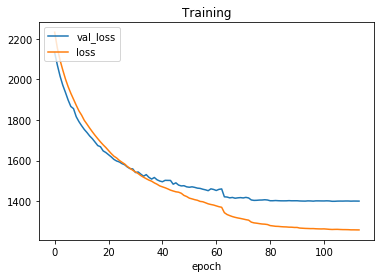

In [6]:
PlotHistory(model.history.history,listKeys=['val_loss','loss']) 

lr   :  [1.5625e-06, 1.5625e-06, 1.5625e-06, 1.5625e-06]


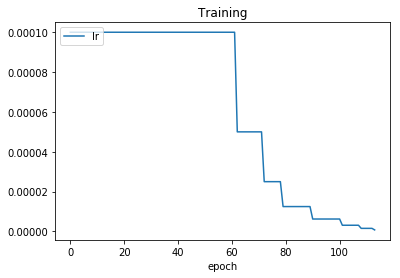

In [7]:
PlotHistory(model.history.history,listKeys=['lr'])

val_acc_pred   :  [0.9535814780060963, 0.9536218418869921, 0.9535861252456583, 0.9535891958462295]
acc_pred   :  [0.9597003216590356, 0.9597540820410492, 0.9597580856686339, 0.9597607006173615]


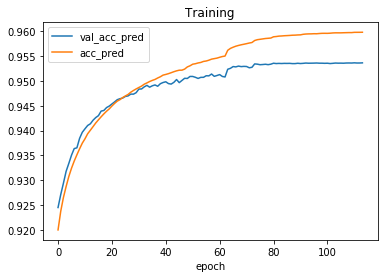

In [8]:
PlotHistory(model.history.history,listKeys=['val_acc_pred','acc_pred'])

# Evaluate Model with Test dataset 

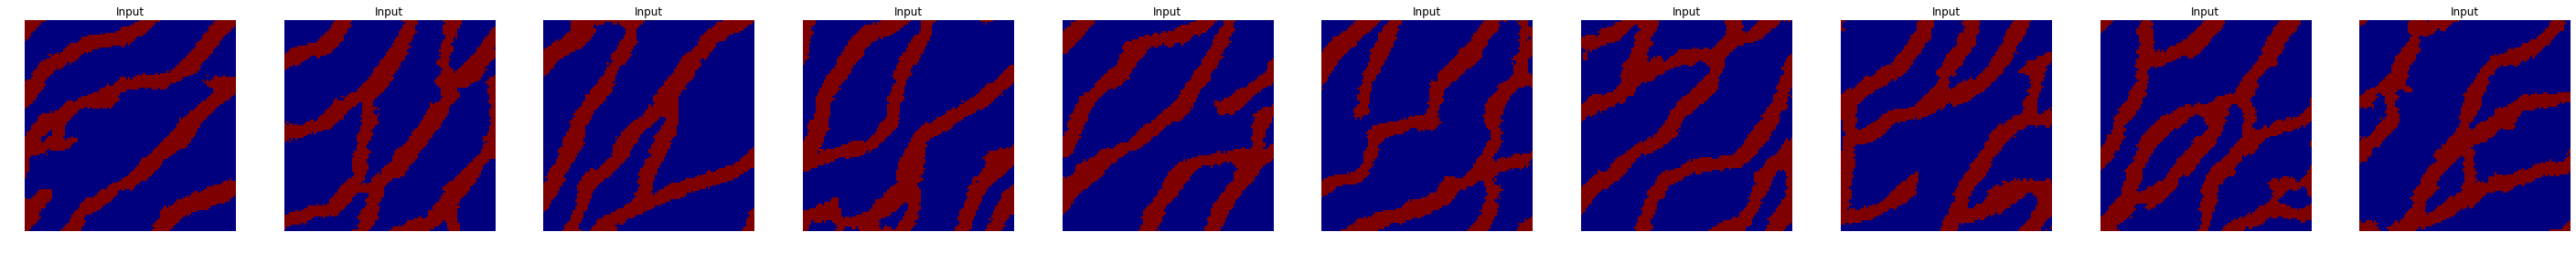

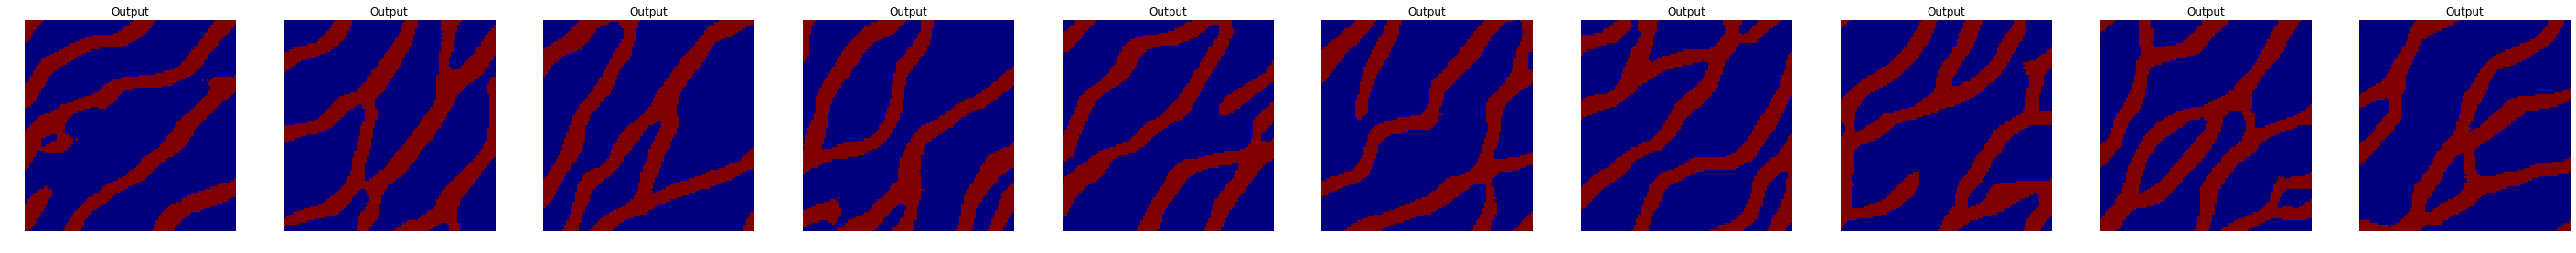

In [9]:
if load_tfrecords:
    x_test = gen_test.get_numpy_batch()

x_rec = model.model.predict(x_test)
PlotDataAE(np.argmax(x_test[:,:,:,:],axis=-1),np.argmax(x_rec[:,:,:,:],axis=-1),digit_size=(100,100))

# Generate random sampling

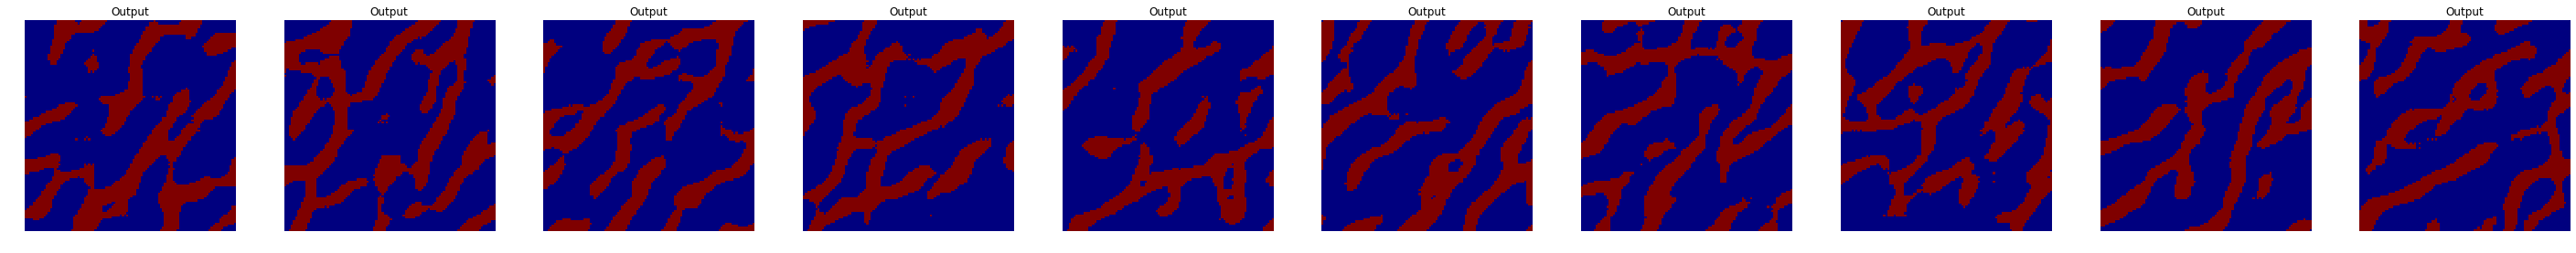

In [10]:
x_gen=model.generate(binary=True)
PlotDataAE([],x_gen[:,:,:],Only_Result=False,digit_size=(100,100))

# Save Encoder and Decoder

In [11]:
Save_Model(model.encoder,'Model/TrainModel/CVAE100_encoder')

In [12]:
Save_Model(model.generator,'Model/TrainModel/CVAE100_decoder')